In [ ]:
import cv2
from keras.models import load_model
import numpy as np
from collections import deque
import os

model = load_model('QuickDraw.h5')


def main():
    emojis = get_QD_emojis()
    cap = cv2.VideoCapture(0)
    Lower_green = np.array([110, 50, 50])
    Upper_green = np.array([130, 255, 255])
    pts = deque(maxlen=512)
    blackboard = np.zeros((480, 640, 3), dtype=np.uint8)
    digit = np.zeros((200, 200, 3), dtype=np.uint8)
    pred_class = 0

    while (cap.isOpened()):
        ret, img = cap.read()
        img = cv2.flip(img, 1)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.inRange(hsv, Lower_green, Upper_green)
        mask = cv2.erode(mask, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        # mask=cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)
        mask = cv2.dilate(mask, kernel, iterations=1)
        res = cv2.bitwise_and(img, img, mask=mask)
        cnts, heir = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        center = None

        if len(cnts) >= 1:
            cnt = max(cnts, key=cv2.contourArea)
            if cv2.contourArea(cnt) > 200:
                ((x, y), radius) = cv2.minEnclosingCircle(cnt)
                cv2.circle(img, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(img, center, 5, (0, 0, 255), -1)
                M = cv2.moments(cnt)
                center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
                pts.appendleft(center)
                for i in range(1, len(pts)):
                    if pts[i - 1] is None or pts[i] is None:
                        continue
                    cv2.line(blackboard, pts[i - 1], pts[i], (255, 255, 255), 7)
                    cv2.line(img, pts[i - 1], pts[i], (0, 0, 255), 2)
        elif len(cnts) == 0:
            if len(pts) != []:
                blackboard_gray = cv2.cvtColor(blackboard, cv2.COLOR_BGR2GRAY)
                blur1 = cv2.medianBlur(blackboard_gray, 15)
                blur1 = cv2.GaussianBlur(blur1, (5, 5), 0)
                thresh1 = cv2.threshold(blur1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                blackboard_cnts, i = cv2.findContours(thresh1.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                print ('black',blackboard_cnts)
                print('thresh',thresh1)
                if len(blackboard_cnts) >= 1:   
                    cnt = max(blackboard_cnts, key=cv2.contourArea)
                    print(cv2.contourArea(cnt))
                    if cv2.contourArea(cnt) > 2000:
                        x, y, w, h = cv2.boundingRect(cnt)
                        digit = blackboard_gray[y:y + h, x:x + w]
                        pred_probab, pred_class = keras_predict(model, digit)
                        print(pred_class, pred_probab)

            pts = deque(maxlen=512)
            blackboard = np.zeros((480, 640, 3), dtype=np.uint8)
            img = overlay(img, emojis[pred_class], 400, 250, 100, 100)
        cv2.imshow("Frame", img)
        k = cv2.waitKey(10)
        if k == 27:
            break


def keras_predict(model, image):
    processed = keras_process_image(image)
    print("processed: " + str(processed.shape))
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class


def keras_process_image(img):
    image_x = 28
    image_y = 28
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (-1, image_x, image_y, 1))
    return img


def get_QD_emojis():
    emojis_folder = 'qd_emo/'
    emojis = []
    for emoji in range(len(os.listdir(emojis_folder))):
        print(emoji)
        emojis.append(cv2.imread(emojis_folder + str(emoji) + '.png', -1))
    return emojis


def overlay(image, emoji, x, y, w, h):
    emoji = cv2.resize(emoji, (w, h))
    try:
        image[y:y + h, x:x + w] = blend_transparent(image[y:y + h, x:x + w], emoji)
    except:
        pass
    return image


def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:, :, :3]  # Grab the BRG planes
    overlay_mask = overlay_t_img[:, :, 3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))


keras_predict(model, np.zeros((50, 50, 1), dtype=np.uint8))
if __name__ == '__main__':
    main()


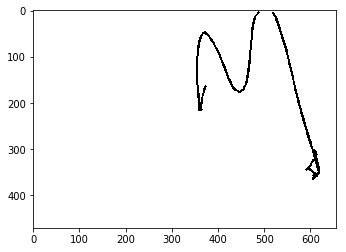

In [10]:
# drawing  using pen


import numpy as np
import cv2
from collections import deque
from matplotlib import pyplot as plt

# Define the upper and lower boundaries for a color to be considered "Blue"
blueLower = np.array([100, 60, 60])
blueUpper = np.array([140, 255, 255])

# Define a 5x5 kernel for erosion and dilation
kernel = np.ones((5, 5), np.uint8)

# Setup deques to store separate colors in separate arrays
points = deque(maxlen=512)

# Setup the Paint interface
paintWindow = np.zeros((471,656,3)) + 255 #paint window
cv2.namedWindow('Paint', cv2.WINDOW_AUTOSIZE)

# Load the video
camera = cv2.VideoCapture(0)

# Keep looping
while True:
    # Grab the current paintWindow
    key = cv2.waitKey(1)
    (grabbed, frame) = camera.read()
    frame = cv2.flip(frame, 1)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Check to see if we have reached the end of the video
    if not grabbed:
        break

    # Determine which pixels fall within the blue boundaries and then blur the binary image
    blueMask = cv2.inRange(hsv, blueLower, blueUpper)
    blueMask = cv2.erode(blueMask, kernel, iterations=2)
    blueMask = cv2.morphologyEx(blueMask, cv2.MORPH_OPEN, kernel)
    blueMask = cv2.dilate(blueMask, kernel, iterations=1)

    # Find contours in the image
    cnts, x  = cv2.findContours(blueMask.copy(), cv2.RETR_EXTERNAL,
    	cv2.CHAIN_APPROX_SIMPLE)
    center = None

    # Check to see if any contours were found
    if len(cnts) > 0:
    	# Sort the contours and find the largest one -- we
    	# will assume this contour correspondes to the area of the bottle cap
        cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        # Get the radius of the enclosing circle around the found contour
        ((x, y), radius) = cv2.minEnclosingCircle(cnt)
        # Draw the circle around the contour
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
        # Get the moments to calculate the center of the contour (in this case Circle)
        M = cv2.moments(cnt)
        
        #finding the center of the circle
        center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
    points.appendleft(center)
    # Append the next deque when no contours are detected (i.e., bottle cap reversed,blue not detected
    for i in range(1,len(points)):
        if points[i-1] is None or points[i] is None:
            continue
        cv2.line(frame, points[i - 1], points[i], (255, 0, 0), 2)
        cv2.line(paintWindow, points[i - 1], points[i], (0, 0, 0), 3)
                

    # Show the frame and the paintWindow image
    cv2.imshow("Tracking_frame", frame)
    cv2.imshow("PaintWindow", paintWindow)
    
    if key & 0xFF == ord('r'):
        points = deque(maxlen=512)
        paintWindow[:,:,:] = 255
    if key & 0xFF == ord('c'):
            plt.imshow(paintWindow)
            plt.show()
	# If the 'q' key is pressed, stop the loop
    if key == 27:
        break

# Cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()
